In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge

# Regresia liniara

Sumar:
* Introducere (algoritmul SGD)
* generarea unui set de date (sinusoida cu zgomot)
* crearea feature-urilor pentru setul ales
* normalizarea setului de date
* calcularea functiei de loss polinomiale si a derivatei acesteia (forma analitica)
* antrenarea (minimizarea functiei de loss) folosind algoritmul SGD
* antrenarea directa folosind ecuatia normala
* regularizarea

In cele ce urmeaza ne vom folosi de algoritmul SGD (Stochastic Gradient Descent) pentru a minimiza o functie de cost. Vom incepe cu o scurta prezentare intuitiva a acestui algoritm.

Pentru aceasta, vom considera o functie convexa (al carei minim este unic), si anume functia $f(x) = x^2$. Pentru aceasta functie, gradientul este usor de calculat analitic, $\frac{\partial f}{\partial x} = 2x$.

Iata cum arata aceasta functie:

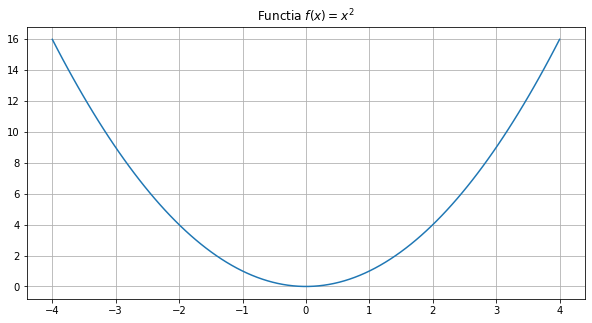

In [2]:
f = lambda x: x * x
grad = lambda x: 2 * x

xf = np.linspace(-4, 4, 100)
yf = f(xf)

def sgd_plot(xf, yf, res=None, title='Functia $f(x)=x^2$'):
    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(xf, yf)
    if res is not None:
        ax.plot(res, [f(x) for x in res], 'o--')
    ax.set_title(title)
    ax.grid() ; plt.show()

sgd_plot(xf, yf)

Algoritmul SGD presupune ca, intr-un punct dat, sa ne deplasam in directia gradientului negativ cu un factor de scala dat. Acest lucru se face pentru un numar prestabilit de epoci:

In [3]:
def sgd(x, eta, epochs):
    res = [x]
    for _ in range(epochs):
        x -= eta * grad(x)
        res += [x]
    return res

Vom pleca din punctul (-3, 9), cu o rata de invatare $\eta = 0.8$ si vom parcurge 4 epoci:

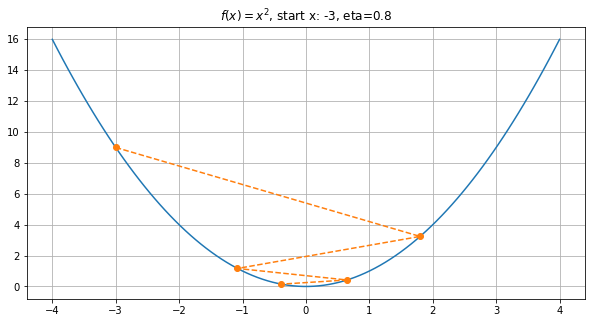

In [4]:
x, eta, epochs = -3, 0.8, 4
res = sgd(x, eta=eta, epochs=epochs)
sgd_plot(xf, yf, res, title=f'$f(x)=x^2$, start x: {x}, eta={eta}')

Se poate vedea cum traiectoria converge incet catre minimul (0, 0).

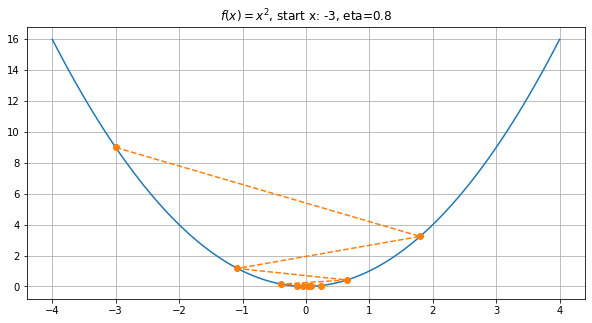

In [5]:
x, eta, epochs = -3, 0.8, 9
res = sgd(x, eta=eta, epochs=epochs)
sgd_plot(xf, yf, res, title=f'$f(x)=x^2$, start x: {x}, eta={eta}')

a) in cate epoci putem spune ca ajungem la zero?

Raspuns: 9 epoci

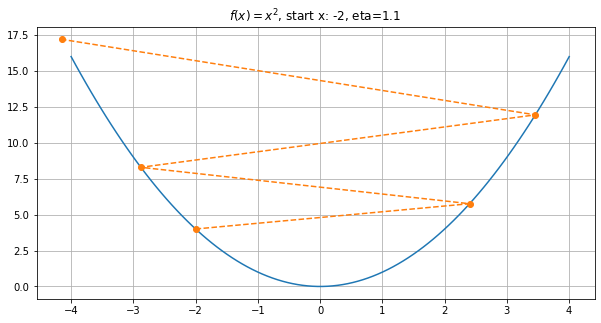

In [6]:
x, eta, epochs = -2, 1.1, 4
res = sgd(x, eta=eta, epochs=epochs)
sgd_plot(xf, yf, res, title=f'$f(x)=x^2$, start x: {x}, eta={eta}')

b) ce se intampla daca plecam din punctul (-2, 4) dar schimbam $\eta = 1.1$?

Raspuns: Avand rata de invatare 1.1, deplasarea in directia gradientului negativ din punctul (-2, 4) se face prea repede ceea ce rezulta in ratarea punctului de minim.

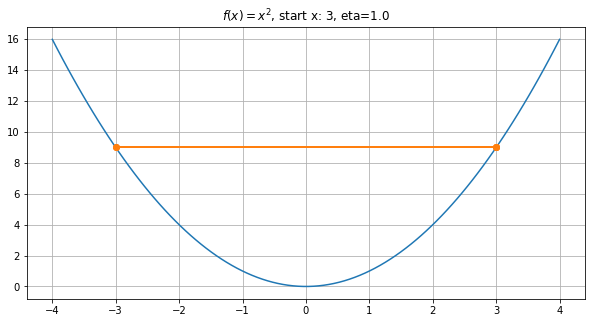

In [7]:
x, eta, epochs = 3, 1.0, 4
res = sgd(x, eta=eta, epochs=epochs)
sgd_plot(xf, yf, res, title=f'$f(x)=x^2$, start x: {x}, eta={eta}')

c) dar daca plecam din punctul (3, 9) dar acum setam $\eta = 1.0$ ?

Raspuns: In acest caz algoritmul sgd genereaza aceleasi doua puncte x = -3 si x = 3 deoarece pasul care are loc in interiorul algoritmului are doar doua posibilitati, fapt datorat ratei de invatare care este 1.

## 1. Setul de date

In [8]:
# generarea datasetului
xs = np.linspace(0, 3 * np.pi, 50)

# initializarea random seed-ului pentru a obtine de fiecare data aceeasi secventa,
# daca se ruleaza de la inceput
np.random.seed(10)
ys = np.sin(xs) + np.random.normal(0, 0.1, len(xs))

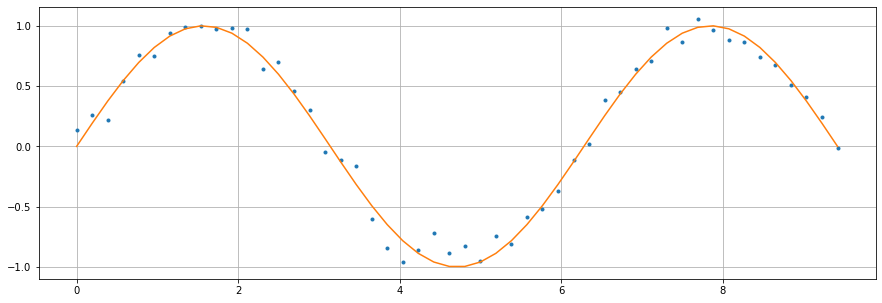

In [9]:
def regr_plot(x, y1, y2):
    """
    Afisarea graficului a doua functii cu acelasi suport; prima folosind puncte si a doua folosind linii
    
    Args:
        x: suportul functiilor (acelasi domeniu)
        y1: valorile primei functii
        y2: valorile celei de-a doua functii
    """
    # cream un singur subplot, cu o linie si o coloana, cu dimensiuni specificate
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(x, y1, '.')
    ax.plot(x, y2, '-')
    ax.grid() ; plt.show()
    
# vom afisa deocamdata setul de puncte pe care vrem sa invatam (xs, ys), precum si functia reala (sinus)
regr_plot(xs, ys, np.sin(xs))

## 2. Crearea feature-urilor

Setul de date are deocamdata doar un singur feature ($x$). Vom lua o functie polinomiala de grad $rank$ pentru a aproxima aceasta curba; acea functie este scrisa astfel:
$$func(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + \dots + \theta_{rank} x^{rank}$$

Vom 'fabrica' featurile corespunzatoare lui $\theta_0$ (aici e simplu, este $x^0 = 1$), $\theta_2 \dots \theta_{rank}$, prin ridicarea la putere a lui $x$. Calculul valorilor functiei pentru toate valorile $x$ se face matricial, astfel:

$$
\left[ \begin{array} \\ func(x_1) \\ func(x_2) \\ \dots \\ func(x_m) \\ \end{array} \right] = 
\left[ \begin{array} \\
1 & x_1 & x_1^2 & \dots & x_1^{rank} \\
1 & x_2 & x_2^2 & \dots & x_2^{rank} \\
\dots & \dots & \dots & \dots & \dots \\
1 & x_m & x_m^2 & \dots & x_m^{rank} \\
\end{array} \right] \cdot
\left[ \begin{array} \\ \theta_1 \\ \theta_2 \\ \dots \\ \theta_{rank} \\ \end{array} \right] = X \theta$$

Putem sa scriem acum functia de loss mai compact astfel:

$$loss(X) = \frac{1}{2m} \|X\theta\ - Y\|^2 = \frac{1}{2} MSE(X\theta - Y)$$

, unde bineinteles $Y = \left[ \begin{array} \\ y_1 & y_2 & \dots & y_m \end{array} \right]^T$. Functia anterioara este denumita si Mean Squared Error (MSE).

In [10]:
def expand(xmic: np.array, rank: int) -> np.array:
    """
    Constructia matricii X
    
    Args
        xmic: vector (numpy array) de dimensiune m
        rank: rangul polinomului
        
    Returns
        X calculat va avea m linii si (rank + 1) coloane, iar pe prima coloana vor fi doar 1-uri
    """
    
    return np.vander(xmic, N = rank + 1, increasing=True)

# calcularea lui X, prin generarea puterilor lui xs pe coloane
# verificare sumara a corectitudinii (dimensiuni si prima coloana)
rank: int = 3
x: np.array = expand(xs, rank)
assert x.shape[0] == len(xs)
assert x.shape[1] == rank + 1
assert np.all(x[:, 0] == 1.)

## 3. Normalizarea setului de date

Fiecare dintre feature-urile calculate anterior (puterile lui $x$, coloanele matricii $X$), are un alt interval de variaţie. Aceste intervale de variaţie trebuie reduse la intervalul $[0, 1]$ (feature-urile trebuiesc scalate), din două motive.

Primul motiv ţine de coeficienţii $\theta_i$. Fiecare feature va influenţa rezultatul final într-o altă măsură, iar coeficienţii, reflectînd cantitatea prin care feature-ul respectiv contribuie la rezultat, nu vor putea fi comparaţi. Pentru a putea compara coeficienţii $\theta_i$ ai regresiei, şi deci contribuţia fiecărui feature, acestea trebuie să aibă acelaşi interval de variaţie.

Al doilea motiv este mult mai practic şi ţine de erori numerice. Astfel, valorile calculate tind sa atingă valori foarte mari care nu mai pot fi reprezentate suficient de precis şi conduc la erori de calcul de tip overflow (depăşirea limitei superioare de reprezentare).

Scalarea se poate face în două feluri. Prima posibilitate este să scalăm feature-urile $x$ în aşa fel încât toate să ajungă la o distribuţie normală de medie $\mu = 0$ şi deviaţie standard $\sigma = 1$, prin scăderea mediei urmată de împărţirea la deviaţia standard:

$$x_n = \frac{x - \mu}{\sigma}$$

Unde media, respectiv deviaţia standard pe coloana $x$ de $m$ elemente sunt definite ca:

$$\mu_x = \frac{1}{m}\sum_{i=1}^{m} x_i$$

$$\sigma^2 = \frac{1}{m}\sum_{i=1}^{m} (x_i - \mu)^2$$

Pentru a înţelege de ce 99.7% dintre valori vor cădea în intervalul $[-3, 3]$ puteţi urmări cursurile 1 şi 2 de la [Inferenţă statistică în Machine Learning](https://github.com/hash2100/statinf).

Noi nu vom folosi această strategie, ci ceva mai simplu.

În cazul nostru, avem o variabilă $x$ al cărei interval de variaţie este $[0, +\infty]$. Pentru a o constrânge în intervalul $[0, 1]$, este suficient să scădem valoarea minimă iar rezultatul să-l împărţim la diferenţa dintre valoarea minimă şi valoarea maximă:

$$x_n = \frac{x - x_{min}}{x_{max} - x_{min}}$$

Pentru matricea $X$ de $m$ linii şi $rank + 1$ coloane, va trebui să scalăm fiecare coloană, în afară de prima, folosind aceste valori minime şi maxime de pe fiecare coloană. Pentru a înţelege cum se lucrează vectorizat, vă rog să revedeţi modul de lucru cu numpy array-uri prezentat în [Cursul 2 de Introducere în Data Science](https://github.com/lmsasu/cursuri/blob/master/Introducere_in_data_science/cursuri/Curs2/Curs2.ipynb). Cu această ocazie revedeţi şi noţiunea de "numpy broadcast".

In [11]:
def normalize(x):
    """
    Normalizarea pe coloane a lui X. Scopul e sa nu avem feature-uri cu variatii diferite (una foarte putin si
    alta foarte mult), ci toate feature-urile să varieze doar în intervalul (0, 1).
    
    Args
        x: matricea de dimensiune m x (rank + 1)
        
    Returns
        O noua matrice pentru care fiecare coloana va fi o variabila aleatoare de medie 0 si dispersie 1.
    """
    min_col = x[:,1:].min(axis=0)
    max_col = x[:,1:].max(axis=0)
    x[:,1:] = (x[:,1:] - min_col) / (max_col - min_col)
    return x

# verificarea faptului ca matricea are coloanele de medie 0 si dispersie 1, cu exceptia primei
x = expand(xs, rank=3)
x_normalized = normalize(x)
assert np.all(x[:, 0] == 1.)
assert np.all((x_normalized[:, 1:] >= 0))
assert np.all((x_normalized[:, 1:] <= 1))

## 4. Calculul functiei de loss

Functia polinomiala $func(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + \dots + \theta_{rank} x^{rank}$ se implementeaza sub forma matriciala $func(X) = X \cdot \theta$ :

In [12]:
def func(x, theta):
    """
    Calcularea functiei polinomiale
    
    Args:
        x: matricea X cu toate featurile calculate de dimensiune m x (rank + 1)
        
    Returns
        Un vector de dimensiune m reprezentind valoarea polinomului in toate cele m valori x
    """
    return np.dot(x, theta)
    
# verificarea implementarii corecte pe un set de coeficienti theta predeterminat
coefs = np.array([2., 1., -2, 1])
x = expand(np.array([0., 1, 2, -1]), 3)

assert np.all(func(x, coefs) == np.array([2., 2, 4, -2]))

Functia de loss este $loss(X) = \frac{1}{2m} \|X \theta - Y\|^2$ si masoara 'cat de departe' este functia polinomiala actuala de valorile $Y$.

In [13]:
def loss(x, y, theta):
    """
    Calcularea functiei de loss pentru toate punctele (x, y)
    
    Args:
        x: matricea X a feature-urilor de dimensiune m x (rank + 1)
        y: vectorul iesirilor dorite Y de dimensiune m
        theta: vectorul parametrilor de dimensiune (rank + 1)
        
    Returns
        O valoare scalara ce reprezinta 1/2 MSE(X * theta - Y)
    """

    return np.power(np.linalg.norm(func(x, theta) - y), 2) / (2 * y.size)

# verificarea sumara a corectitudinii
coefs = np.array([2., 1., -2, 1])
x = expand(np.array([0., 1, 2, -1, -2]), 3)
assert loss(x, np.array([2., 2, 4, -2, -16]), coefs) == 0.

Pentru functia $loss(X) = \frac{1}{2m} \|X \theta - Y\|^2$, gradientul in raport cu directia $\theta$ se calculeaza astfel:

$$grad(X, theta) = \nabla_{\theta} loss(X) = \frac{1}{m} X^T (X \theta - Y)$$

In [14]:
def grad(x, y, theta, lmbda=0):
    """
    Calculul gradientului dupa directia theta in punctul X
    
    Args:
        x: matricea X a feature-urilor, de dimensiune m x (rank + 1) 
        y: vectorul Y de dimensiune m
        theta: vectorul parametrilor de dimensiune (rank + 1)
        lmbda: parametrul de regularizare (optional)
        
    Returns:
        gradientii pentru toate punctele x, vector de dimensiune m
        
    Observatii
        * initial nu implementati regularizarea (factorul lambda)
        * pentru implementarea cu lambda, atentie la \theta_0 (vedeti cursul)
    """
    
    return np.dot(np.transpose(x), (func(x, theta) - y)) / y.size

coefs = np.array([2., 1., -2, 1])
x = expand(np.array([0., 1, 2, -1, -2]), 3)
y = np.array([2., 2, 4, -2, -16])

assert np.all(grad(x, y, coefs) == np.array([0.] * 4))

'Antrenarea' parametrilor nu este altceva decat minimizarea repetata a functiei de loss, prin avansul parametrilor $\theta$ in directia gradientului negativ.

Functia de antrenare (train) va itera un numar de epoci, iar la fiecar epoca parametrul $\theta$ se va modifica:

$$\theta \leftarrow \theta - \eta \cdot grad(X, Y, \theta)$$

1. prima data ignoram parametrul batch si actualizam gradientul la fiecare epoca;

2. dupa ce verificam functionalitatea, implementam si versiunea batch gradient descent: dupa fiecare batch (aici = 10) samples, actualizam coeficientii $\theta$. Nu parcurgeti din 10 in 10, ci la fiecare epoca amestecati indicii liniilor lui x, astfel incat cele 10 sample-uri dupa care faceti update-ul lui $\theta$ sa fie amestecate.

    De exemplu, daca am avea un numar de 12 sample-uri in total si un batch de dimensiune 3, o ordonare triviala pe batc-uri ar fi:
    batch1 = (0, 1, 2) 
    batch2 = (3, 4, 5)
    batch3 = (6, 7, 8)
    batch4 = (9, 10, 11)
    
    O ordonare stochastica (aleatoare) ar putea arata astfel (ceea ce trebuie sa implementati):
    batch1 = (2, 10, 4) 
    batch2 = (1, 11, 6)
    batch3 = (7, 3, 8)
    batch4 = (9, 0, 5)
    
    Versiunea batch stochastic gradient ar trebui sa va conduca la un loss final mai redus.
    
    
## 5. Antrenarea folosind SGD

In [15]:
def train(xs, ys, rank=3, eta=0.1, epochs=20, batch=10, lmbda=0.):
    """
    Procedura de antrenare, de minizimare a coeficientilor functiei polinomiale
    
    Args:
        xs: feature-urile X, de dimensiune m x (rank + 1)
        ys: valorile Y, vector de dimensiune m
        rank: gradul polinomului
        eta: denumit si rata de invatare (learning rate); o valoare buna la inceput este 0.1 (o zecime)
        epochs: numarul de iteratii (epoci)
        batch: dimensiunea unui batch
        lmbda: regularization lambda
        
    Returns:
        tupla de 3 elemente: X-ul normalizat, theta initial si theta antrenat
    """
    x = expand(xs, rank)
    assert x.shape[0] == len(xs)
    assert x.shape[1] == rank + 1
    
    coefs = np.random.normal(size=rank + 1)
    coefs_init = coefs.copy()
    assert len(coefs) == rank + 1
    
    x = normalize(x)
    
    print(f'initial loss: {loss(x, ys, coefs)}')

    for epoch in range(epochs):
        # pentru fiecare epoca, se actualizeaza variabila coefs
        samples = np.random.permutation(x.shape[0])
        for index in range(0, x.shape[0], batch):
            x_batch = np.take(x, samples[index : index + batch], axis=0)
            y_batch = np.take(ys, samples[index : index + batch])
            coefs = coefs - eta * grad(x_batch, y_batch, coefs, lmbda)
        
    print(f'loss on epoch {epoch}: {loss(x, ys, coefs)}')
    
    return x, coefs, coefs_init

initial loss: 1.330486232764636
loss on epoch 99999: 0.006548671640480064


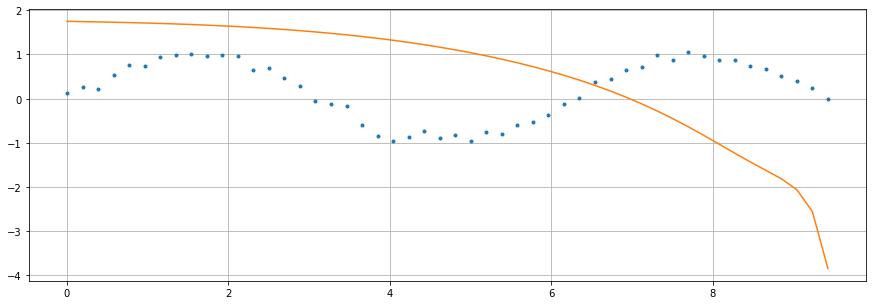

In [16]:
# impunem o anume alegere aleatorie, pentru repetabilitate
np.random.seed(11)
# antrenam modelul
x, coefs, coefs_init = train(xs, ys, rank=50, eta=0.6, epochs=100000) # eta = 0.01
# asa arata regresia cu coeficientii luati initial aleator
regr_plot(xs, ys, func(x, coefs_init))

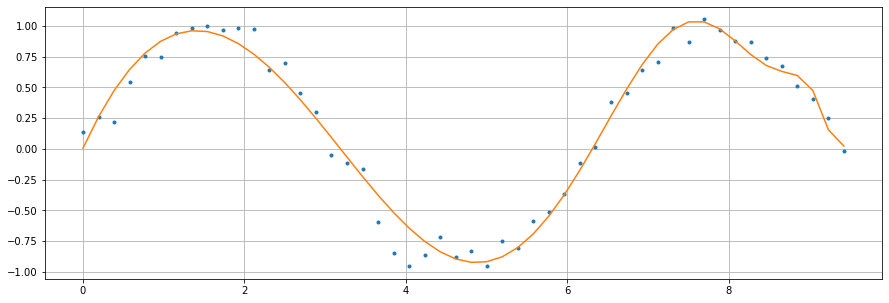

0.006548671640480064

In [17]:
# asa arata regresia cu coeficientii antrenati
regr_plot(xs, ys, func(x, coefs))
loss(x, ys, coefs) # loss-ul trebuie sa fie undeva la 0.03, sau 0.007 putin pentru varianta cu batch-uri

## 6. Calcul direct folosind ecuatia normala

Cazul regresiei liniare este un caz fericit, pentru ca avem o solutie analitica pentru $\theta$:

$$\theta = (X^T X)^{-1} X^T Y$$

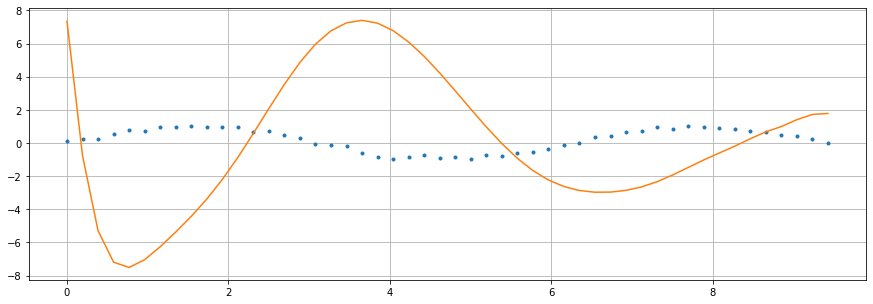

10.30166521266666

In [18]:
# calculam solutia analitic 
theta = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(x), x)), np.transpose(x)), ys)
# afisam comparativ solutia analitica si calculam loss-ul asociat
regr_plot(xs, ys, func(x, theta))
loss(x, ys, theta) # loss-ul este in jurul lui 5.7

## 7.1 Regularizarea



Pentru acest exemplu, este destul de dificil de vazut efectul regularizarii pentru algoritmul SGD (necesita multi pasi de antrenare). Efectul se poate vedea bine insa pentru calculul direct folosind ecuatia caracteristica, in care am introdus termenul de regularizare:

$$\theta = (X^T X + 2 \lambda I_{rank+1})^{-1} X^T Y$$

Vom urmari, pe langa reprezentarea grafica a regresiei polinomiale, care este loss-ul pentru setul de date X precum si suma valorilor absolute ale coeficientilor, $\sum_i |\theta_i|$. Scopul regularizarii este sa avem coeficienti de valori cat mai mici; aceasta deoarece la o valoare mare a unui coeficient $\theta_i$, o variatie mica a feature-ului corespunzator $x_i$ se traduce intr-o variatie foarte mare a functiei polinomiale - overfitting. Vrem sa evitam acest lucru.

In [19]:
lmbda = 0.000
theta0 = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x) + 2 * lmbda * np.identity(x.shape[0] + 1)), x.T), ys)
lmbda = 0.001
theta1 = np.dot(np.dot(np.linalg.inv(np.dot(x.T, x) + 2 * lmbda * np.identity(x.shape[0] + 1)), x.T), ys)

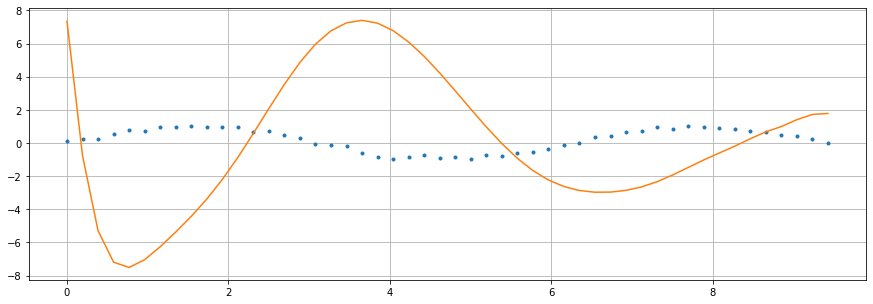

loss(x, ys, theta0): 10.30166521266666, sum(theta0) 1458481528.6797364


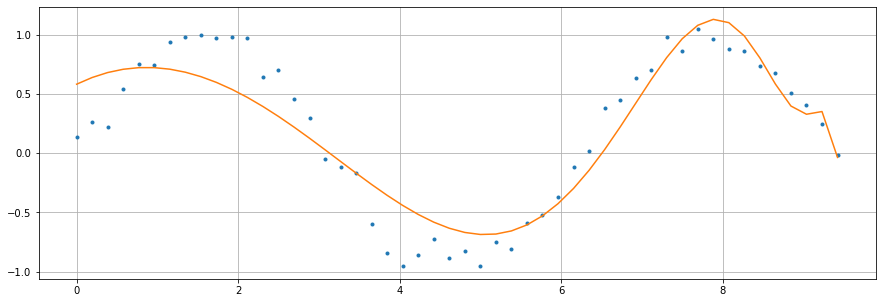

loss(x, ys, theta1): 0.03160276640226614, sum(theta1) 116.4792208686255


In [20]:
regr_plot(xs, ys, func(x, theta0))
print(f'loss(x, ys, theta0): {loss(x, ys, theta0)}, sum(theta0) {np.abs(theta0).sum()}')
regr_plot(xs, ys, func(x, theta1))
print(f'loss(x, ys, theta1): {loss(x, ys, theta1)}, sum(theta1) {np.abs(theta1).sum()}')

## 7.2 Regularizarea folosind modelele sklearn

Modelele de regresie liniara sunt implementate in bibiloteca SciKit Learn:
https://scikit-learn.org/stable/modules/linear_model.html

Le vom folosi pentru a realiza cat de importanta este regularizarea parametrilor modelului.

In primul exemplu, vom folosi modelul de regresie liniara simpla, fara regularizare:

$$min_{\theta} \|X \theta - Y\|^2$$

In [21]:
from sklearn.linear_model import LinearRegression, Ridge

rank = 50
x = expand(xs, rank)
assert x.shape[0] == len(xs)
assert x.shape[1] == rank + 1

linreg = LinearRegression(normalize=True)
linreg.fit(x, ys)
y_pred = linreg.predict(x)

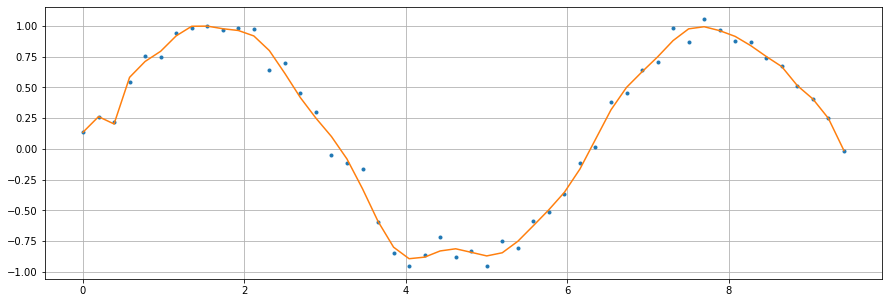

loss: 0.18186736571777876, sum(theta): 429963456205.89746


In [22]:
regr_plot(xs, ys, y_pred)
print(f'loss: {np.sum((ys - y_pred) ** 2)}, sum(theta): {np.abs(linreg.coef_).sum()}')

Functia de loss cu regularizare este:

$$min_{\theta} \|X \theta - Y\|^2 + \lambda \|\theta\|^2$$

Acest tip de regresie cu regularizare se numeste Ridge Regression:

In [23]:
linreg = Ridge(alpha=1e-12, normalize=True)
linreg.fit(x, ys)
y_pred = linreg.predict(x)

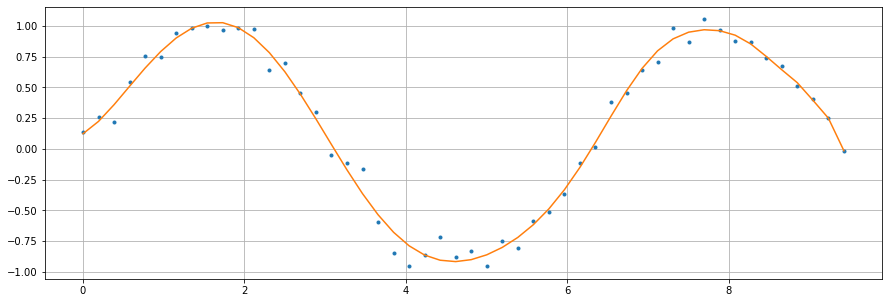

loss: 0.2955101514215597, sum(theta): 2.4180893647051813


In [24]:
regr_plot(xs, ys, y_pred)
print(f'loss: {np.sum((ys - y_pred) ** 2)}, sum(theta): {np.abs(linreg.coef_).sum()}')

In [25]:
lmbda = [1., 0.1, 0.01, 0.001, 0.0001, 1e-6, 1e-8, 1e-12]
y_res = []
sum_abs = []
for a in lmbda:
    linreg = Ridge(alpha=a, normalize=True)
    linreg.fit(x, ys)
    y_pred = linreg.predict(x)
    y_res.append(y_pred)
    sum_abs.append(np.abs(linreg.coef_).sum())

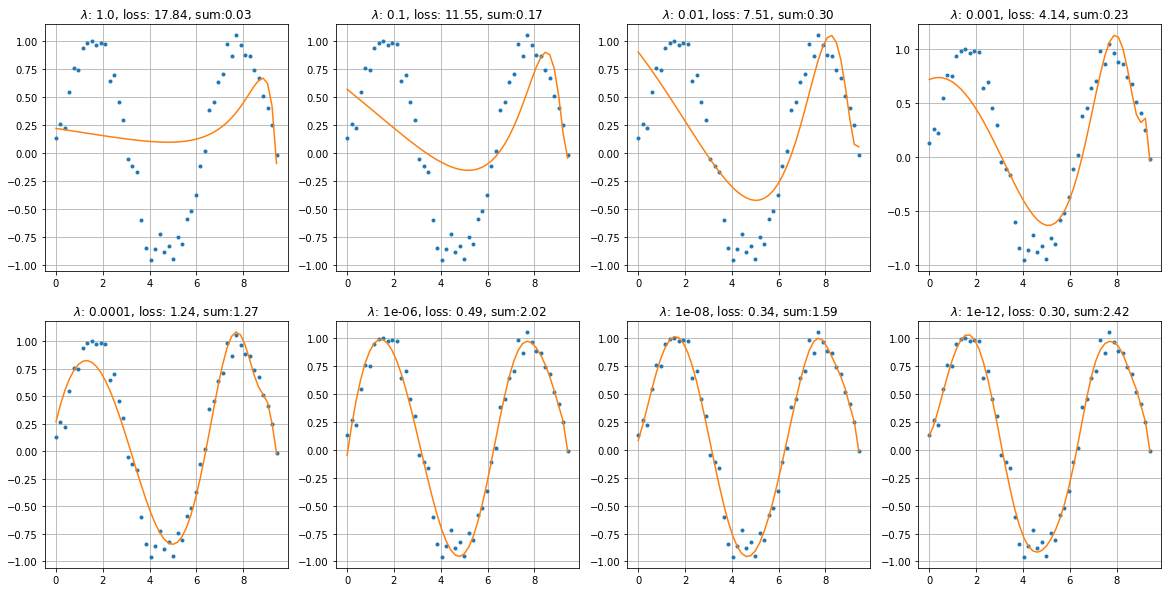

In [35]:
# modificati codul de mai jos in asa fel incat pentru fiecare varianta (coeficent de regularizare) sa afisati
# si loss-ul corespunzator respectiv suma valorii absolute a coeficientilor (2 zecimale)
# ... TODO ...
float_formatter = "{:.2f}".format
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(len(y_res)):
    ax[i // 4, i % 4].plot(xs, ys, '.')
    ax[i // 4, i % 4].plot(xs, y_res[i], '-')
    ax[i // 4, i % 4].grid()
    
    loss = np.sum((ys - y_res[i]) ** 2)
    ax[i//4, i % 4].set_title(f'$\lambda$: {lmbda[i]}, loss: {float_formatter(loss)}, sum:{float_formatter(sum_abs[i])}')

plt.show()